IPSuite uses [DVC](https://dvc.org) to manage its files and workflows. In this part we will fit different GAP models to our data and compare them.

In [1]:
import ipsuite as ips

/data/fzills/miniconda3/envs/ipsuite/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
2023-04-09 13:27:19.209319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 13:27:19.278392: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different co

2023-04-09 13:27:21,104 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


In [2]:
with ips.Project() as project:
    data = ips.AddData(file="KCl1650K.extxyz", lines_to_read=100)
    test_data = ips.configuration_selection.UniformEnergeticSelection(
        data=data, n_configurations=10, name="test_data"
    )
    # we have now given the Nodes a "name" attribute to uniquly identify them
    train_data = ips.configuration_selection.RandomSelection(
        data=data,
        n_configurations=5,
        exclude_configurations=test_data.exclude_configurations,
        name="train_data",
    )
    model = ips.models.GAP(data=train_data, OPENBLAS_NUM_THREADS="1")
    prediction = ips.analysis.Prediction(model=model, data=test_data)
    analyse = ips.analysis.PredictionMetrics(data=prediction)
project.run()


Running DVC command: 'stage add --name AddData --force ...'
Running DVC command: 'stage add --name test_data --force ...'
Running DVC command: 'stage add --name train_data --force ...'
Running DVC command: 'stage add --name MLModel --force ...'
Running DVC command: 'stage add --name Prediction --force ...'
Running DVC command: 'stage add --name PredictionMetrics --force ...'
Running DVC command: 'repro'
/data/fzills/miniconda3/envs/ipsuite/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
2023-04-09 13:27:25.204141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfe

2023-04-09 13:27:26,053 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


Reading File: 100it [00:00, 462.23it/s]


We can now invesitage our Model.

In [3]:
analyse.load()
print(analyse.energy)
print(analyse.forces)

{'rmse': 0.13339214891809859, 'mae': 0.07440080493761343, 'max': 0.35914482074440457, 'lp4': 0.03661996585967021, 'rrmse': 0.034715587601414515}
{'rmse': 0.07416969827004116, 'mae': 0.05800122770633783, 'max': 0.28791852165573506, 'lp4': 0.0005568084094838176, 'rrmse': 0.19659564575716554}


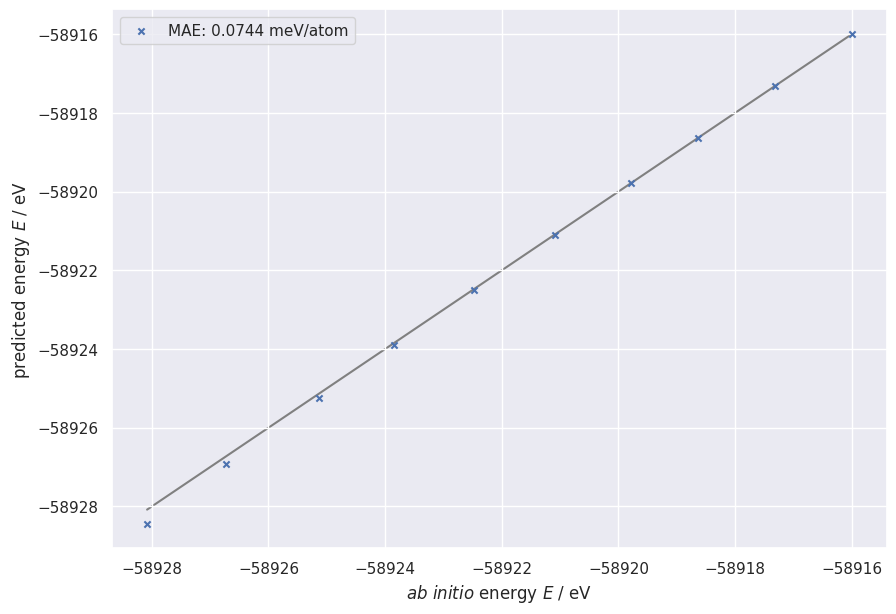

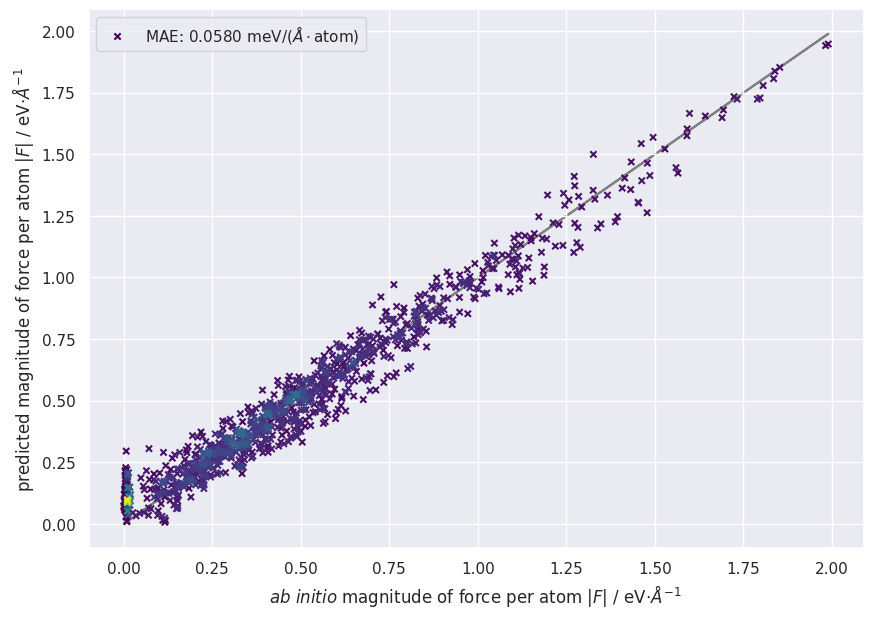

In [4]:
analyse.get_plots()

We can use `dvc dag --mermaid` to display the graph that was created for us:

[![](https://mermaid.ink/img/pako:eNpdkdFKwzAUhl-lnOtt2Lm20AtBnFdbQfRC0IiE5tQG0mSkp7o69u6edV1Xe3fy_X8OH8kBcqcQUiiM-8lL6SnYPgsryDIO3wXcK7WWJAV8XOjyRK00bY1PHpXOSTs7ym853zyYMI5uNgvc0779XajvfNRYcSPbZjyZEY2Y9gtfNZXTOOaYvNT2U_33SU4B1jTl4Xx-112cgmQw7UE4iPUgGpx6sBwspo2kB6spiGEGFfpKasXPexA2CNizxAoFpDwqLGRjSICwR642O9bHR6XJeUjJNzgD2ZB7aW1-OZ87ay2_vKwgLaSpme6kfXPuesZuR3b-1u53j3-xQ6q3?type=png)](https://mermaid.live/edit#pako:eNpdkdFKwzAUhl-lnOtt2Lm20AtBnFdbQfRC0IiE5tQG0mSkp7o69u6edV1Xe3fy_X8OH8kBcqcQUiiM-8lL6SnYPgsryDIO3wXcK7WWJAV8XOjyRK00bY1PHpXOSTs7ym853zyYMI5uNgvc0779XajvfNRYcSPbZjyZEY2Y9gtfNZXTOOaYvNT2U_33SU4B1jTl4Xx-112cgmQw7UE4iPUgGpx6sBwspo2kB6spiGEGFfpKasXPexA2CNizxAoFpDwqLGRjSICwR642O9bHR6XJeUjJNzgD2ZB7aW1-OZ87ay2_vKwgLaSpme6kfXPuesZuR3b-1u53j3-xQ6q3)

If we want to train our model on a different amount of training data, we can modify the `train_data` Node.
This will only rerun nodes that are dependent on the `train_data` Node. In our case, this means that the `test_data` Node won't be affect and we can ensure, that all models are evaluated on the same test data.

To compare `experiments` we need to create them first.

In [5]:
with project.create_experiment(name="baseline") as exp1 :
    # this will store the current experiment with the name "baseline"
    pass

with project.create_experiment() as exp2:
    train_data.n_configurations = 10

with project.create_experiment() as exp3:
    train_data.n_configurations = 3

project.run_exp()

Running DVC command: 'exp run --queue --name baseline'
Running DVC command: 'exp run --queue'
Running DVC command: 'exp run --queue'
Running DVC command: 'exp run --run-all --jobs 1'


Now let's have a look at the results. We can load the Experiments using `exp.load` followed by `exp.nodes['node-name']` or  via `Node.from_rev(rev=<name>)`.

In [6]:
for exp in [exp3, exp1, exp2]:
    exp.load()
    print(f"'{exp.name}': {exp['train_data'].n_configurations = }")

'runny-byte': exp['train_data'].n_configurations = 3
'baseline': exp['train_data'].n_configurations = 5
'still-frit': exp['train_data'].n_configurations = 10


In [7]:
print(analyse.from_rev(rev=exp3.name).energy)
print(analyse.from_rev(rev=exp1.name).energy)
print(analyse.from_rev(rev=exp2.name).energy)

{'rmse': 0.06843546094628307, 'mae': 0.04337811411023722, 'max': 0.16644362638908206, 'lp4': 0.01759224278700481, 'rrmse': 0.017810472796135658}
{'rmse': 0.13339214891809859, 'mae': 0.07440080493761343, 'max': 0.35914482074440457, 'lp4': 0.03661996585967021, 'rrmse': 0.034715587601414515}
{'rmse': 0.0609839700508201, 'mae': 0.03502517837769119, 'max': 0.16625131168984808, 'lp4': 0.01689277787756151, 'rrmse': 0.015871206602130372}


You can also use the CLI `dvc exp show` to compare your experiments.


To make these Experiments persistent and store them inside your GIT repository there are multiple options:
- you can use `dvc exp branch <exp> <branch>` and push that branch to your remote.
- you can use `dvc exp apply <exp>` and commit the experiment and push to your remote.

To store all experiments, you can make temporary branches using `dvc exp branch` and then consecutively merge them into the branch you want them to be stored in.

In [8]:
# We want to remove the experiments here, so we can rerun the Notebook.
!dvc exp remove -A

Removed experiments: 'baseline', 'still-frit' and 'runny-byte'        
